In [5]:
import sys
sys.path.append("../") 

In [6]:
import pandas as pd
import numpy as np

In [7]:
from epimodel.preprocessing import preprocess_data
from epimodel.epiparam import EpidemiologicalParameters

In [8]:
data = preprocess_data("../data/synth_data_small.csv")

In [9]:
ep = EpidemiologicalParameters()

# construct model

In [25]:
nRs = 40
nDs = 114

In [81]:
nNP = jnp.ceil(nDs / 7)

noise = np.random.normal(size=(40, int(nNP)))

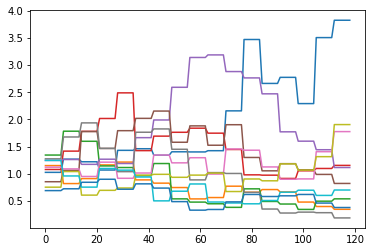

In [82]:
plt.plot(np.exp(np.repeat(np.cumsum(noise * 0.25, axis=-1), 7, axis=-1)[:data.nRs, :data.nDs].T))

In [ ]:
log_Rt_noise = r_walk_noise_scale * jnp.repeat(jnp.cumsum(noisepoint_log_Rt_noise_series, axis=-1), noise_scale_period, axis=-1)

In [21]:
x = np.array([[1, 2], [3, 4]])

In [24]:
x.repeat(7, axis=1)

array([[1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2],
       [3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4]])

In [10]:
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
from jax import random
import jax.numpy as jnp
import jax.scipy.signal as jss

import jax

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
def model(data, ep, ar_noise=0.01, ifr_noise=0.01, r_noise_scale=0.05):
    # data has nCMs, nRs, nDs as attributes
    alpha_i = numpyro.sample("alpha_i", dist.TruncatedNormal(low=-0.1, loc=np.zeros(data.nCMs), scale=0.2)) 
    cm_reduction = jnp.sum(data.active_cms * alpha_i.reshape((1, data.nCMs, 1)), axis=1)
    
    basic_R_variation = numpyro.sample("basic_R_variation", dist.HalfNormal(5))
    basic_R = numpyro.sample("R_base", dist.TruncatedNormal(low=0.1, loc=1.5*jnp.ones(data.nRs), scale=basic_R_variation))
    log_Rt_noise = numpyro.sample("log_Rt_noise", dist.Normal(loc=np.zeros((data.nRs, data.nDs))))
    log_Rt = jnp.log(basic_R.reshape((data.nRs, 1))) - cm_reduction + log_Rt_noise * r_noise_scale
    
    Rt = numpyro.deterministic('Rt', jnp.exp(log_Rt)) # nRs x nDs
    
    seeding_padding = 7
    total_padding = ep.GIv.size-1
    
    seeding_scale = numpyro.sample("seeding_scale", dist.HalfNormal(3))
    seeding = numpyro.sample("seeding", dist.LogNormal(jnp.zeros((data.nRs, 1)), scale=seeding_scale))
    
    init_infections = jnp.zeros((data.nRs, total_padding))
    init_infections = jax.ops.index_add(init_infections, jax.ops.index[:, -seeding_padding:], jnp.repeat(seeding, seeding_padding, axis=-1))
    
    total_infections = jnp.zeros((data.nRs, seeding_padding + data.nDs))
    
    infection_noise_scale = numpyro.sample("infection_noise_scale", dist.HalfNormal(3))
    infection_noise = numpyro.sample("infection_noise", dist.HalfNormal(infection_noise_scale*jnp.ones((data.nRs, data.nDs))))
    
    def discrete_renewal_transition(infections, R_with_noise_tuple):
        # infections is an nR x total_padding size array of infections in the previous 
        # total_padding days. 
        R, inf_noise = R_with_noise_tuple
        new_infections = infections @ ep.GI_projmat
        new_infections = jax.ops.index_update(new_infections, jax.ops.index[:, -1], jnp.multiply(new_infections[:, -1], R) + inf_noise)
        return new_infections, new_infections[:, -1]
    
    # we need to transpose R because jax.lax.scan scans over the first dimension. We want to scan over time
    # we also will transpose infections at the end 
    _, infections = jax.lax.scan(discrete_renewal_transition, init_infections, [Rt.T, infection_noise.T])
    
    total_infections = jax.ops.index_update(total_infections, jax.ops.index[:, :seeding_padding], init_infections[:, -seeding_padding:])
    total_infections = jax.ops.index_update(total_infections, jax.ops.index[:, seeding_padding:], infections.T)
    
    total_infections = numpyro.deterministic('total_infections', total_infections)
    
    ar_rw = numpyro.sample("ar_rw", dist.Normal(np.zeros((data.nRs, data.nDs+seeding_padding)), ar_noise))
    # i.e., ar_0 is 1.
    ar_t = numpyro.deterministic('ar_t', jnp.exp(jnp.cumsum(ar_rw, axis=-1)))
    
    # lazy - probably can do better than uniform. 
    ifr_0 = numpyro.sample("ifr_0", dist.Uniform(low=0.01, high=np.ones((data.nRs, 1))))
    ifr_rw = numpyro.sample("ifr_rw", dist.Normal(np.zeros((data.nRs, data.nDs+seeding_padding)), ifr_noise)) 
    ifr_t = numpyro.deterministic('ifr_t', ifr_0 * jnp.exp(jnp.cumsum(ifr_rw, axis=-1)))

    future_cases_t = numpyro.deterministic('future_cases_t', jnp.multiply(total_infections, ar_t))
    future_deaths_t = numpyro.deterministic('future_deaths_t', jnp.multiply(total_infections, ifr_t))
        
    expected_cases = numpyro.deterministic('expected_cases', jss.convolve2d(future_cases_t, ep.DPCv, mode='full')[:, seeding_padding:data.nDs+seeding_padding])
    expected_deaths = numpyro.deterministic('expected_deaths', jss.convolve2d(future_deaths_t, ep.DPDv, mode='full')[:, seeding_padding:data.nDs+seeding_padding])
    psi_cases = numpyro.sample("psi_cases", dist.HalfNormal(5))
    psi_deaths = numpyro.sample("psi_deaths", dist.HalfNormal(5))
    
    with numpyro.handlers.mask(mask=np.logical_not(data.new_cases.mask)):
        observed_cases = numpyro.sample("observed_cases", dist.GammaPoisson(concentration=psi_cases, rate=psi_cases/expected_cases), obs=data.new_cases.data)
        
    with numpyro.handlers.mask(mask=np.logical_not(data.new_deaths.mask)):
        observed_deaths = numpyro.sample("observed_deaths", dist.GammaPoisson(concentration=psi_deaths, rate=psi_deaths/expected_deaths), obs=data.new_deaths.data)

In [19]:
from numpyro.infer import init_to_median

In [20]:
from numpyro.infer import init_to_median
nuts_kernel = NUTS(model, init_strategy = init_to_median)

mcmc = MCMC(nuts_kernel, num_samples=8000, num_warmup=2000)
rng_key = random.PRNGKey(0)

with numpyro.validation_enabled():
    res = mcmc.run(rng_key, data, ep)

posterior_samples = mcmc.get_samples(np.array([0]))

warmup:   0%|          | 45/10000 [01:39<6:07:36,  2.22s/it, 1023 steps of size 1.82e-03. acc. prob=0.72]


KeyboardInterrupt: 

# validate results

In [16]:
np.median(posterior_samples['alpha_i'], axis=0)

array([-0.0922296 , -0.02480441,  0.02960566,  0.11717707,  0.32023165,
        0.23702009,  0.11831836,  0.14161979,  0.22399722,  0.34911132],
      dtype=float32)

In [18]:
np.percentile(posterior_samples['alpha_i'], 97.5, axis=0)

array([-0.06273155,  0.04780565,  0.10314327,  0.2071218 ,  0.38541228,
        0.30720744,  0.19270417,  0.20892247,  0.2982357 ,  0.403318  ])

In [ ]:
all_df = pd.read_csv('../data/synth_data_small.csv')
all_df['date'] = pd.to_datetime(all_df['date'])
all_df = all_df.set_index(['area', 'date'])

In [ ]:
for r_i, r in enumerate(data.Rs):
    plt.figure(figsize=(6, 6), dpi=300)
    
    plt.subplot(331)
    plt.plot(data.Ds, np.median(posterior_samples['Rt'][:, r_i, :], axis=0), color='tab:purple')
    plt.plot(data.Ds, all_df.loc[r].loc[data.Ds]['R'], color='k')
    plt.fill_between(data.Ds, np.percentile(posterior_samples['Rt'][:, r_i, :], 2.5, axis=0), np.percentile(posterior_samples['Rt'][:, r_i, :], 97.5, axis=0), color='tab:purple', alpha=0.5)
    plt.xticks(fontsize=3, rotation=-45, ha='left')
    plt.title('$R_t$', fontsize=8)
    
    plt.subplot(332)
    plt.plot(data.Ds, np.percentile(np.exp(np.cumsum(posterior_samples['ar_rw'][:, r_i, 7:], axis=-1)), 50, axis=0), color='tab:purple')
    plt.plot(data.Ds, all_df.loc[r].loc[data.Ds]['AR']/all_df.loc[r].loc[data.Ds[0]]['AR'], color='k')
    plt.fill_between(data.Ds, np.percentile(np.exp(np.cumsum(posterior_samples['ar_rw'][:, r_i, 7:], axis=-1)), 2.5, axis=0), np.percentile(np.exp(np.cumsum(posterior_samples['ar_rw'][:, r_i, 7:], axis=-1)), 97.5, axis=0), color='tab:purple', alpha=0.5)
    plt.xticks(fontsize=3, rotation=-45, ha='left')
    plt.title('$\Delta\ AR_t$', fontsize=8)
    
    plt.subplot(333)
    plt.plot(data.Ds, np.percentile(np.exp(np.cumsum(posterior_samples['ifr_rw'][:, r_i, 7:], axis=-1)), 50, axis=0), color='tab:purple')
    plt.plot(data.Ds, all_df.loc[r].loc[data.Ds]['IFR']/all_df.loc[r].loc[data.Ds[0]]['IFR'], color='k')
    plt.fill_between(data.Ds, np.percentile(np.exp(np.cumsum(posterior_samples['ifr_rw'][:, r_i, 7:], axis=-1)), 2.5, axis=0), np.percentile(np.exp(np.cumsum(posterior_samples['ifr_rw'][:, r_i, 7:], axis=-1)), 97.5, axis=0), color='tab:purple', alpha=0.5)
    plt.xticks(fontsize=3, rotation=-45, ha='left')
    plt.title('$\Delta\ IFR_t$', fontsize=8)
    
    plt.subplot(334)
    plt.plot(data.Ds, np.percentile(5*posterior_samples['total_infections'][:, r_i, 7:], 50, axis=0), color='tab:purple')
    plt.plot(data.Ds, all_df.loc[r].loc[data.Ds]['N'], color='k')
    plt.fill_between(data.Ds, np.percentile(5*posterior_samples['total_infections'][:, r_i, 7:], 2.5, axis=0), np.percentile(5*posterior_samples['total_infections'][:, r_i, 7:], 97.5, axis=0), color='tab:purple', alpha=0.5)
    plt.xticks(fontsize=3, rotation=-45, ha='left')
    plt.title('$N$', fontsize=8)
    plt.yscale('log')
    
    plt.subplot(335)
    plt.plot(data.Ds, np.percentile(posterior_samples['expected_cases'][:, r_i, :], 50, axis=0), color='tab:purple')
    plt.scatter(data.Ds, all_df.loc[r].loc[data.Ds]['new_cases'], color='k', s=6)
    plt.fill_between(data.Ds, np.percentile(posterior_samples['expected_cases'][:, r_i, :], 2.5, axis=0), np.percentile(posterior_samples['expected_cases'][:, r_i, :], 97.5, axis=0), color='tab:purple', alpha=0.5)
    plt.xticks(fontsize=3, rotation=-45, ha='left')
    plt.title('Cases', fontsize=8)
    
    plt.subplot(336)
    plt.plot(data.Ds, np.percentile(posterior_samples['expected_deaths'][:, r_i, :], 50, axis=0), color='tab:purple')
    plt.scatter(data.Ds, all_df.loc[r].loc[data.Ds]['new_deaths'], color='k', s=6)
    plt.fill_between(data.Ds, np.percentile(posterior_samples['expected_deaths'][:, r_i, :], 2.5, axis=0), np.percentile(posterior_samples['expected_deaths'][:, r_i, :], 97.5, axis=0), color='tab:purple', alpha=0.5)
    plt.xticks(fontsize=3, rotation=-45, ha='left')
    plt.title('Deaths', fontsize=8)
    
    plt.subplot(337)
    plt.plot(data.Ds, np.percentile(5*posterior_samples['total_infections'][:, r_i, 7:], 50, axis=0), color='tab:purple')
    plt.plot(data.Ds, all_df.loc[r].loc[data.Ds]['N']*all_df.loc[r].loc[data.Ds]['AR'], color='k')
    plt.fill_between(data.Ds, np.percentile(5*posterior_samples['total_infections'][:, r_i, 7:], 2.5, axis=0), np.percentile(5*posterior_samples['total_infections'][:, r_i, 7:], 97.5, axis=0), color='tab:purple', alpha=0.5)
    plt.xticks(fontsize=3, rotation=-45, ha='left')
    plt.title('$FC_t$', fontsize=8)
    plt.yscale('log')
    
    plt.tight_layout()
    plt.suptitle(f'{r}', y=1.01)

In [ ]:
sns.kdeplot(posterior_samples['g'][:, 0].flatten())